# Импорт библиотек и данных

Launch a server via:
```bash
mlflow server --host 127.0.0.1 --port 8080
```

In [1]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
from mlflow.models import infer_signature

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate,\
    GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

root_folder = '../'
sys.path.append(root_folder)

from src.visualization import visualize
from src.models import train_model
from src.utils import get_dict

preprocessed_data = Path(root_folder, 'data', 'interim', '2.0_preprocessed.csv')

Подготовим датасет и проведём корреляционный тест (корреляция Пирсона)

<class 'pandas.core.frame.DataFrame'>
Index: 330799 entries, 0 to 374305
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   baths                       330799 non-null  float64
 1   fireplace                   330799 non-null  bool   
 2   beds                        330799 non-null  float64
 3   stories                     330799 non-null  float64
 4   private_pool                330799 non-null  bool   
 5   mls                         330799 non-null  bool   
 6   parking_count               330799 non-null  float64
 7   central_heating             330799 non-null  bool   
 8   central_cooling             330799 non-null  bool   
 9   log_target                  330799 non-null  float64
 10  log_sqft                    330799 non-null  float64
 11  log_lotsize                 330799 non-null  float64
 12  updated_years               330799 non-null  float64
 13  school_count       

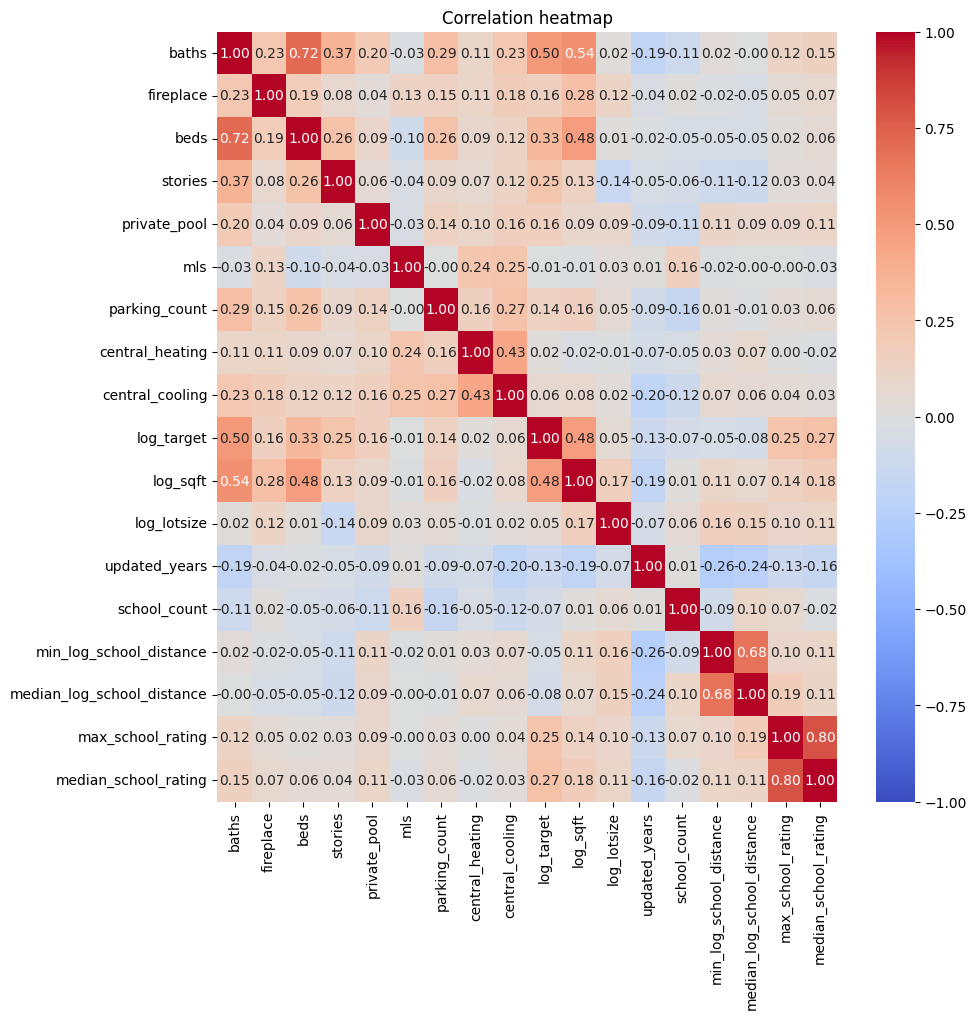

In [5]:
df = pd.read_csv(
    preprocessed_data,
    index_col=0
)
df = df.drop(df.columns[df.dtypes=='object'], axis=1)
df = df.drop(['target'], axis=1)
df.info()
df.describe()

fig = visualize.plot_heatmap(
    df.corr(),
    title='Correlation heatmap',
);
fig.set_size_inches(10,10)

Близкие к мультиколлинерным пары:
- median_school_rating и max_school_rating
- beds и baths

В дальнейшем, возможно имеет смысл выбросить один из признаков.

На логарифм целевого признака влияют больше всего количество спален и ванн, а также жилая площадь 

In [10]:
# Prepare data
X, y = train_model.get_X_y(df, target_name='log_target')

X shape: (330799, 17)
y shape: (330799,)


Проводим обучение и оценку метрик в кросс-валидации

In [11]:
# random_state = 42

# Prepare pipe
imputer_params = get_dict(
    missing_values=np.nan,
    strategy='median'
)
pipe_elements = [
    ('imputer', SimpleImputer, imputer_params),
    ('scaler', MinMaxScaler),
    ('regressor', LinearRegression)
]
pipe, pipe_params = train_model.make_pipeline(pipe_elements)
display(pipe)

# Conduct fitting and cross-validation metrics estimation
metrics = train_model.cross_validate_pipe(
    pipe=pipe,
    X=X,
    y=y,
)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()), ('regressor', LinearRegression())])

,train,test
mape,0.041,0.041
r2,0.379,0.379


Получили гораздо лучше результат, чем был на baseline

In [12]:
pipe.fit(X, y)
print('WARNING: fit on all data')

model_info = train_model.log_pipe_mlflow(
    pipe_name='eda-linreg',
    training_info='Linear regression with eda',
    X=X,
    pipe=pipe,
    pipe_params=pipe_params,
    metrics=metrics,
)

/home/vulf/.cache/pypoetry/virtualenvs/housing-cost-EeioB1ZZ-py3.11/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'eda-linreg'.
2024/04/23 01:59:28 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ed

Посмотрим на поведение дерева решений на этом же датасете, 
предваритально подобрав оптимальную максимальную глубину (по r2)

In [13]:
# Prepare pipe
imputer_params = get_dict(
    missing_values=np.nan,
    strategy='median'
)
dtree_params = get_dict(
    # max_depth=20,
    random_state=42
)
pipe_elements = [
    ('imputer', SimpleImputer, imputer_params),
    ('scaler', MinMaxScaler),
    ('regressor', DecisionTreeRegressor, dtree_params)
]
pipe, pipe_params = train_model.make_pipeline(pipe_elements)
display(pipe)

max_depth_grid = [2, 4, 8, 10, 12, 16, 20, 24, 28, 32, 64, 128]
grid = GridSearchCV(
    pipe,
    param_grid={
        'regressor__max_depth': max_depth_grid,
    },
    scoring=(
        'neg_mean_absolute_error',
        'r2'
    ),
    refit='r2',
    n_jobs=-1,
    return_train_score=True,
)
grid.fit(X, y)
# print(f'Best mean absolute error: {-grid.best_score_:.3e}')
print(f'Best r2-score: {grid.best_score_:.3f}')
print(f'Best params:', grid.best_params_)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()),
                ('regressor', DecisionTreeRegressor(random_state=42))])

Best r2-score: 0.463
Best params: {'regressor__max_depth': 12}


In [14]:
# random_state = 42

# Prepare pipe
imputer_params = get_dict(
    missing_values=np.nan,
    strategy='median'
)
dtree_params = get_dict(
    max_depth=12,
    random_state=42
)
pipe_elements = [
    ('imputer', SimpleImputer, imputer_params),
    ('scaler', MinMaxScaler),
    ('regressor', DecisionTreeRegressor, dtree_params)
]
pipe, pipe_params = train_model.make_pipeline(pipe_elements)
display(pipe)

# Conduct fitting and cross-validation metrics estimation
metrics = train_model.cross_validate_pipe(
    pipe=pipe,
    X=X,
    y=y,
)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()),
                ('regressor',
                 DecisionTreeRegressor(max_depth=12, random_state=42))])

,train,test
mape,0.035,0.037
r2,0.537,0.463


Логируем дерево решений

In [16]:
pipe.fit(X, y)
print('WARNING: fit on all data')

model_info = train_model.log_pipe_mlflow(
    pipe_name='eda-dtree',
    training_info='Decision tree with eda',
    X=X,
    pipe=pipe,
    pipe_params=pipe_params,
    metrics=metrics,
)

/home/vulf/.cache/pypoetry/virtualenvs/housing-cost-EeioB1ZZ-py3.11/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/vulf/.cache/pypoetry/virtualenvs/housing-cost-EeioB1ZZ-py3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but imp

## Выводы по бейзлайнам

Таким образом, одним лишь EDA удалось значительно улучшить метрики

Получены метрики:
- **MAPE**: $0.037$ (то есть ошибка $3.7\%$, но это ошибка в степени 10)
- **R^2**: $0.46$ vs $0.22$